In [1]:
import numpy as np
import os
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, make_scorer
from dataPreprocessing import DataPreprocessing

# classifiers
from classification.ElkanotoSVCClassifier import ElkanotoSVCClassifier
from sklearn.svm import SVC

# Classification pipeline

In [2]:
# Global parameters
doPreprocessing = True # whether to generate the files for those feature sets
featureSets = [{ "kmer_simple": [3, 6]}, { "kmer_simple": [3] }, { "kmer_simple": [6] }]

# define data to use
hostsToIncludeInTrainingData = [10036, 10090, 1644094, 9031, 9455, 9534, 9544, 9823, 9913]
hostsToBuildClassifierFor = [10036]
featureFileToUse = "features_kmer_simple-3-6.csv"

# paths
featureFileFolder = "../features"
featureFilePrefix = "features"
genomeParentFolder = "../viral_genomes"

In [3]:
# Preprocessing means regenerating the feature files for the chosen feature sets
if doPreprocessing:
    # get all hosts
    allHosts = [f.name for f in os.scandir(genomeParentFolder) if f.is_dir()]
    filesForHosts = {host: [f.name for f in os.scandir(f"{genomeParentFolder}/" + host) if f.is_file()] for host in allHosts}

    # filter out files that exist in multiple hosts
    nonUnique = set()
    for host in allHosts:
        for otherHost in allHosts:
            if host != otherHost:
                appearInBoth = set(filesForHosts[host]).intersection(set(filesForHosts[otherHost]))
                nonUnique = nonUnique.union(appearInBoth)
    for host in allHosts:
        filesForHosts[host] = [f for f in filesForHosts[host] if f not in nonUnique]

    # create feature files
    for featureSet in featureSets:
        # feature file suffix
        suffix = ""
        for k, v in featureSet.items():
            suffix += f"_{k}"
            for val in v:
                suffix += f"-{val}"
        print("Creating feature set " + suffix)

        # extract features
        with open(f"{featureFileFolder}/{featureFilePrefix}{suffix}.csv", "w") as featureFile:
            dataPreprocessor = DataPreprocessing.DataPreprocessing()
            for host in allHosts:
                print ("Extracting features for host: " + host)
                for genomeFilename in filesForHosts[host]:
                    with open(f"{genomeParentFolder}/{host}/{genomeFilename}", "r") as genomeFile:
                        # get sequence
                        lines = genomeFile.readlines()
                        sequence = "".join(lines[1:]).replace("\n", "")
                        # flatten feature dict to list
                        features = [x for v in dataPreprocessor.extractFeaturesFromGenome(sequence, featureSet).values() for x in v]
                        # write as csv
                        featureFile.write(host + "," + genomeFilename.split(".")[0] + "," + ",".join(map(str, features)) + "\n")

Creating feature set _kmer_simple-3-6
Extracting features for host: 10036
Extracting features for host: 10090
Extracting features for host: 1644094
Extracting features for host: 9031
Extracting features for host: 9455
Extracting features for host: 9534
Extracting features for host: 9544
Extracting features for host: 9823
Extracting features for host: 9913
Creating feature set _kmer_simple-3
Extracting features for host: 10036
Extracting features for host: 10090
Extracting features for host: 1644094
Extracting features for host: 9031
Extracting features for host: 9455
Extracting features for host: 9534
Extracting features for host: 9544
Extracting features for host: 9823
Extracting features for host: 9913
Creating feature set _kmer_simple-6
Extracting features for host: 10036
Extracting features for host: 10090
Extracting features for host: 1644094
Extracting features for host: 9031
Extracting features for host: 9455
Extracting features for host: 9534
Extracting features for host: 9544


In [3]:
# Create dictionary of hosts (as key) and lists (of feature lists for each virus) (as value)
featuresPerHost = {}
for host in hostsToIncludeInTrainingData:
    featuresPerHost[host] = []

# Load features of virus sequences for each host in seperate list and convert them to a np array
print("Loading features")
with open(f"{featureFileFolder}/{featureFileToUse}") as featureFile:
    for line in featureFile:
        # split csv
        values = line.rstrip().split(",")
        # get host
        host = int(values[0])
        if host in hostsToIncludeInTrainingData:
            # if host should be loaded, save features for this virus
            featuresPerHost[host].append(list(map(float, values[2:])))
for host in hostsToIncludeInTrainingData:
    featuresPerHost[host] = np.array(featuresPerHost[host])

Loading features


In [4]:
# choose classifiers
classifiers = {}
for host in hostsToBuildClassifierFor:
    classifiers[host] = SVC(kernel='rbf')

# Transform features (X) and host classes (y) into expected format for classifier
# exclude hosts that have no values in the training data
X = np.concatenate([featuresPerHost[host] for host in hostsToIncludeInTrainingData if featuresPerHost[host].shape[0] > 0])

def getYForHost(h):
    y = []
    for host in hostsToIncludeInTrainingData:
        y += [1 if host == h else 0] * len(featuresPerHost[host])
    return np.array(y)

scores = {}
specificity = make_scorer(recall_score, pos_label=0)
for host in hostsToBuildClassifierFor:
    print("Running cross validation for host:", host)
    # load the training data
    X = X
    y = getYForHost(host)

    # run k-fold cross validation
    cv = KFold(n_splits=4, shuffle=True)
    scores[host] = cross_validate(classifiers[host], X, y, cv=cv, n_jobs=4, scoring={'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall', 'specificity': specificity, 'precision': 'precision', 'f1': 'f1'})

Running cross validation for host: 10036


Results for host: 10036
Balanced accuracy: [0.81428571 0.77777778 0.76470588 0.81259513]
Recall: [0.62857143 0.55555556 0.52941176 0.63888889]
Specificity: [1.         1.         1.         0.98630137]
Precision: [1.        1.        1.        0.9787234]
F1: [0.77192982 0.71428571 0.69230769 0.77310924]


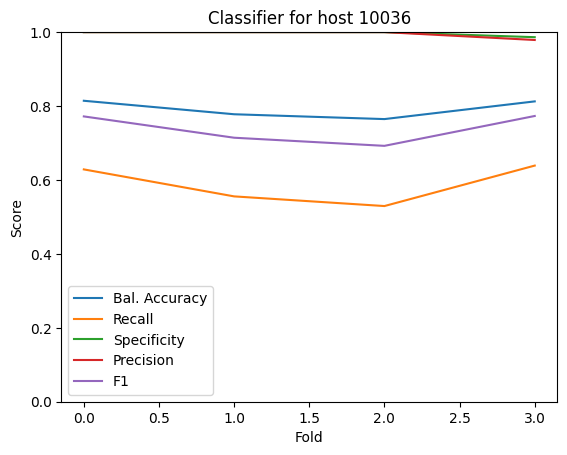

In [5]:
# Plot results
import matplotlib.pyplot as plt

for host in hostsToBuildClassifierFor:
    print("Results for host:", host)
    print("Balanced accuracy:", scores[host]['test_balanced_accuracy'])
    print("Recall:", scores[host]['test_recall'])
    print("Specificity:", scores[host]['test_specificity'])
    print("Precision:", scores[host]['test_precision'])
    print("F1:", scores[host]['test_f1'])

    plt.plot(scores[host]['test_balanced_accuracy'], label='Bal. Accuracy')
    plt.plot(scores[host]['test_recall'], label='Recall')
    plt.plot(scores[host]['test_specificity'], label='Specificity')
    plt.plot(scores[host]['test_precision'], label='Precision')
    plt.plot(scores[host]['test_f1'], label='F1')

    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Fold")

    plt.legend()
    plt.title(f"Classifier for host {host}")
    plt.show()

# Research

['10036', '10090', '1644094', '9031', '9455', '9534', '9544', '9823', '9913']


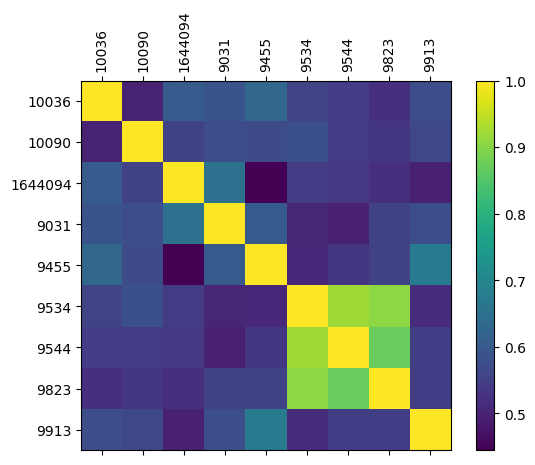

In [ ]:
# Research how many viruses overlap between hosts
import os
import matplotlib.pyplot as plt

allHosts = [f.name for f in os.scandir(genomeParentFolder) if f.is_dir()]
filesForHosts = {host: [f.name for f in os.scandir(f"{genomeParentFolder}/{host}") if f.is_file()] for host in allHosts}
print(allHosts)

# create a confustion matrix of the host files
confusionMatrix = []
for i, host in enumerate(allHosts):
    confusionMatrix.append([0] * len(allHosts))
    for j, host2 in enumerate(allHosts):
        confusionMatrix[i][j] = len(set(filesForHosts[host]).intersection(set(filesForHosts[host2]))) / min(len(filesForHosts[host]), len(filesForHosts[host2]))

# plot heatmap
fig, ax = plt.subplots()
cax = ax.matshow(confusionMatrix, )
fig.colorbar(cax)
plt.xticks(range(len(allHosts)), allHosts, rotation=90)
plt.yticks(range(len(allHosts)), allHosts)
plt.show()

We can see that there is at least a ~45% overlap for each host.

# Old results (for future reference)

In [ ]:
# Elkanoto w/o unique virus filtering (+ different features)
# elkanoto_svc_results = {1644094: {'fit_time': array([4907.15073395, 4990.56171942, 4950.51426482, 4881.92315793]), 'score_time': array([1155.61685181, 1191.37233377, 1176.45055175, 1254.34660721]), 'test_balanced_accuracy': array([0.5       , 0.5       , 0.5       , 0.50102549]), 'test_recall': array([1., 1., 1., 1.]), 'test_specificity': array([0.        , 0.        , 0.        , 0.00205098]), 'test_precision': array([0.11694696, 0.123674  , 0.11875809, 0.11715915]), 'test_f1': array([0.20940468, 0.22012434, 0.21230342, 0.20974478])}, 10090: {'fit_time': array([534.51305532, 619.46996903, 592.92223024, 604.51297069]), 'score_time': array([187.53446698, 171.91070223, 181.0747714 , 168.35237956]), 'test_balanced_accuracy': array([0.5       , 0.61592175, 0.5       , 0.38738078]),'test_recall': array([1.        , 0.94230769, 1.        , 0.68965517]), 'test_specificity': array([0.        , 0.2895358 , 0.        , 0.08510638]), 'test_precision': array([0.01552393, 0.0177665 , 0.01655886, 0.01135396]), 'test_f1': array([0.03057325, 0.03487544, 0.03257826, 0.02234013])}, 10036: {'fit_time': array([8393.32273841, 8297.76433659, 8338.97264695, 8418.57178783]), 'score_time': array([1768.69770193, 1731.56972361, 1732.82323742, 1774.01409435]), 'test_balanced_accuracy': array([0.49907882, 0.49741666, 0.50031706, 0.49821664]), 'test_recall': array([0.99563953, 0.99008499, 1.        , 0.9954955 ]), 'test_specificity': array([0.0025181 , 0.00474834, 0.00063412, 0.00093779]), 'test_precision': array([0.17773742, 0.18188915, 0.18405384, 0.17180617]), 'test_f1': array([0.30162924, 0.30732029, 0.31088763, 0.29303867])}, 9913: {'fit_time': array([4604.48881054, 4645.48022342, 4221.3886528 , 4642.48942566]), 'score_time': array([1108.71009684, 1121.05930471, 1162.92115974, 1088.92917538]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([1., 1., 1., 1.]), 'test_specificity': array([0., 0., 0., 0.]), 'test_precision': array([0.11228978, 0.11021992, 0.12005175, 0.10349288]), 'test_f1': array([0.20190742, 0.19855512, 0.21436821, 0.18757327])}, 9823: {'fit_time': array([3012.83791757, 3059.24084091, 3229.53498507, 3181.73191714]), 'score_time': array([799.33551478, 842.05273533, 808.06591558, 797.54948783]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([1., 1., 1., 1.]), 'test_specificity': array([0., 0., 0., 0.]), 'test_precision': array([0.08667529, 0.08382924, 0.07218629, 0.07270375]), 'test_f1': array([0.15952381, 0.15469086, 0.13465251, 0.13555234])}, 9544: {'fit_time': array([3095.12177825, 2976.99537325, 3123.85219169, 3244.73573923]),'score_time': array([774.44141483, 845.29702067, 806.54878998, 806.88626552]), 'test_balanced_accuracy': array([0.5       , 0.5       , 0.50013959, 0.50055975]), 'test_recall': array([1., 1., 1., 1.]), 'test_specificity': array([0.        , 0.        , 0.00027917, 0.00111951]), 'test_precision': array([0.08279431, 0.08150065, 0.07324017, 0.07562808]), 'test_f1': array([0.15292712, 0.1507177 , 0.13648421, 0.14062124])}, 9534: {'fit_time': array([3538.9825871 , 3668.4609971 , 3604.55383062, 3706.58384895]), 'score_time': array([952.44729257, 889.66033769, 911.11520481, 914.77577758]), 'test_balanced_accuracy': array([0.54417822, 0.5       , 0.52842069, 0.5       ]), 'test_recall': array([0.98680739, 1.        , 0.99125364, 1.        ]), 'test_specificity':array([0.10154905, 0.        , 0.06558773, 0.        ]), 'test_precision': array([0.10667427, 0.09003881, 0.09363812, 0.0915912 ]), 'test_f1': array([0.19253539, 0.16520294, 0.17111223, 0.16781228])}, 9455: {'fit_time': array([6848.16912031, 7427.41147518, 7640.42564702, 7323.24975252]), 'score_time': array([1687.09556961, 1779.03239751, 1698.843575  , 1638.78948259]), 'test_balanced_accuracy': array([0.50172847, 0.50131404, 0.50046282, 0.50387237]), 'test_recall': array([1.        , 0.99366086, 1.        , 1.        ]), 'test_specificity': array([0.00345695, 0.00896722, 0.00092564, 0.00774473]), 'test_precision': array([0.17721847, 0.16362213, 0.16157431, 0.16588542]), 'test_f1': array([0.30108001, 0.28097692, 0.27819884, 0.28456556])}, 9031: {'fit_time': array([7942.13983655, 7360.12914085, 7180.73114204, 8050.09637523]), 'score_time': array([1712.94993877, 1640.6033814 , 1590.65490031, 1658.59115052]),'test_balanced_accuracy': array([0.50491899, 0.50329869, 0.50630963, 0.50232414]), 'test_recall': array([0.99840764, 0.99655172, 1.        , 1.        ]), 'test_specificity': array([0.01143034, 0.01004566, 0.01261927, 0.00464828]), 'test_precision': array([0.1638359 , 0.15091384, 0.16108787, 0.16571429]), 'test_f1': array([0.28148148, 0.26213152, 0.27747748, 0.28431373])}}
# SVC w/o unique virus filtering (+ different features)
# svc_results = {1644094: {'fit_time': array([921.37710714, 804.73525739, 849.66964531, 926.64888024]), 'score_time': array([1414.27110267, 1283.12198019, 1460.35749292,1442.47194767]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 10090: {'fit_time': array([101.54810452, 157.45918989, 150.07447815,154.34451008]), 'score_time': array([200.94267321, 192.54084754, 195.76825142, 193.88725185]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 10036: {'fit_time': array([1371.72377682, 1347.67116475, 1320.66009974, 1371.74286461]), 'score_time': array([2003.450207  , 2182.99576569, 2356.71167111, 2530.73926139]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 9913: {'fit_time': array([790.12615657, 759.92083788, 729.9546597 , 752.15770316]), 'score_time': array([1260.32520485, 1186.58301377, 1169.35508847, 1281.872684  ]), 'test_balanced_accuracy': array([0.5, 0.5,0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 9823: {'fit_time': array([416.86714387, 610.88384724, 535.68782258, 586.4245491 ]), 'score_time': array([879.4391768 , 845.10344362, 930.64229822, 862.7680912 ]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 9544: {'fit_time': array([507.69800401, 496.05915666, 523.17737341, 523.77310085]), 'score_time': array([866.88913274, 864.84455323, 894.51292753, 860.77611113]), 'test_balanced_accuracy': array([0.5, 0.5,0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 9534: {'fit_time': array([601.23839355, 578.76752949, 597.39624858, 590.59732056]), 'score_time': array([1037.36745787, 1008.62105083,  985.8596127 , 1005.7146101 ]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity':array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}, 9455: {'fit_time': array([1083.14667535, 1084.87314177, 1117.90640569, 1054.55059648]), 'score_time': array([1865.39292979, 1863.74345636, 1849.86681223, 1859.77698636]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]),'test_f1': array([0., 0., 0., 0.])}, 9031: {'fit_time': array([ 988.47512722, 1004.13777328, 1036.66497159, 1018.71995115]), 'score_time': array([1729.89951301, 1717.98967385, 1814.62169409, 1829.67017055]), 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5]), 'test_recall': array([0., 0., 0., 0.]), 'test_specificity': array([1., 1., 1., 1.]), 'test_precision': array([0., 0., 0., 0.]), 'test_f1': array([0., 0., 0., 0.])}}